In [ ]:
!pip install transformers
!pip install accelerate -U
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 3.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments , AutoModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
fpath = './data/'
balanced_df = pd.read_csv(fpath+'labeled_preprocessed_165k.csv')

In [ ]:
balanced_df['label'].value_counts()

label
neutral     34405
sadness     33083
joy         28027
anger       27136
surprise    25243
disgust      9479
fear         8601
Name: count, dtype: int64

In [ ]:
balanced_df

,Unnamed: 0.1,Unnamed: 0,text,label
0,12,12,contemplating giving iphone bandwagon simply c...,sadness
1,14,14,battery painful charge overnight lunchtime bat...,sadness
2,38,38,new iphone standing sir piously bad standing c...,sadness
3,58,58,having phone actually killing paying replacement,sadness
4,70,70,feeling broken phones screen replaced iphone h...,sadness
...,...,...,...,...
165969,282530,282530,veronica visit reel feed,neutral
165970,13487,13487,ave samsung mobile devices lam software galler...,neutral
165971,286805,286805,chicken pink,neutral
165972,161063,161063,ultimate pruning machine sta type bar blade sh...,neutral


In [ ]:
balanced_df['label'].count()

165974

In [ ]:
# Convert the 'text' column to strings
balanced_df['text'] = balanced_df['text'].astype(str)

In [ ]:
texts = balanced_df['text'].tolist()
labels = balanced_df['label'].tolist()

In [ ]:
# Split the data into training and validation sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.fit_transform(test_labels)

In [ ]:
# Load the RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(set(labels)))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the training and test texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
# Create PyTorch DataLoader for training and test data
train_dataset = TensorDataset(
    torch.tensor(train_encodings["input_ids"]),
    torch.tensor(train_encodings["attention_mask"]),
    torch.tensor(train_labels_encoded)
    )

test_dataset = TensorDataset(
    torch.tensor(test_encodings["input_ids"]),
    torch.tensor(test_encodings["attention_mask"]),
    torch.tensor(test_labels_encoded)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 3

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Evaluation
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(labels.tolist())

# Calculate evaluation metrics
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      5418
           1       0.87      0.58      0.70      1825
           2       0.79      0.82      0.81      1740
           3       0.86      0.81      0.83      5709
           4       0.87      0.70      0.78      6911
           5       0.78      0.88      0.83      6493
           6       0.71      0.85      0.77      5099

    accuracy                           0.80     33195
   macro avg       0.81      0.79      0.79     33195
weighted avg       0.81      0.80      0.80     33195



In [ ]:
model.save_pretrained("model")

In [ ]:
tokenizer.save_pretrained("model")

('trained_model_roberta/tokenizer_config.json',
 'trained_model_roberta/special_tokens_map.json',
 'trained_model_roberta/vocab.json',
 'trained_model_roberta/merges.txt',
 'trained_model_roberta/added_tokens.json')

In [ ]:
model_load = RobertaForSequenceClassification.from_pretrained('trained_model_roberta').to(device)

In [ ]:
model_load.config

RobertaConfig {
  "_name_or_path": "trained_model_roberta",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.33.1",
  "ty

In [ ]:
model_load.eval()
predictions_load, true_labels_load = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs_load = model_load(input_ids, attention_mask=attention_mask)
        logits_load = outputs_load.logits
        predictions_load.extend(torch.argmax(logits_load, dim=1).tolist())
        true_labels_load.extend(labels.tolist())

# Calculate evaluation metrics
print(classification_report(true_labels_load, predictions_load))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      5418
           1       0.76      0.84      0.80      1825
           2       0.91      0.74      0.82      1740
           3       0.85      0.87      0.86      5709
           4       0.88      0.74      0.80      6911
           5       0.85      0.86      0.85      6493
           6       0.77      0.86      0.81      5099

    accuracy                           0.83     33195
   macro avg       0.84      0.83      0.83     33195
weighted avg       0.84      0.83      0.83     33195



In [ ]:
model_load.eval()
predictions2, true_labels2 = [], []

with torch.no_grad():
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs_load = model_load(input_ids, attention_mask=attention_mask)
        logits_load = outputs_load.logits
        predictions2.extend(torch.argmax(logits_load, dim=1).tolist())
        true_labels2.extend(labels.tolist())

# Calculate evaluation metrics
print(classification_report(predictions2, true_labels2))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95     22752
           1       0.94      0.89      0.92      8127
           2       0.87      0.97      0.92      6105
           3       0.95      0.92      0.94     22962
           4       0.86      0.97      0.92     24370
           5       0.95      0.94      0.95     26808
           6       0.95      0.89      0.92     21655

    accuracy                           0.93    132779
   macro avg       0.93      0.93      0.93    132779
weighted avg       0.93      0.93      0.93    132779



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(true_labels2, predictions2)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[21024   253    24    53    74   196    94]
 [  262  7226     9    18    62    39    38]
 [  309   155  5943    46    48   168   192]
 [   57    10    19 21213   191   152   676]
 [  453   126    48  1201 23738   624  1304]
 [  507   305    39   115   174 25292   158]
 [  140    52    23   316    83   337 19193]]


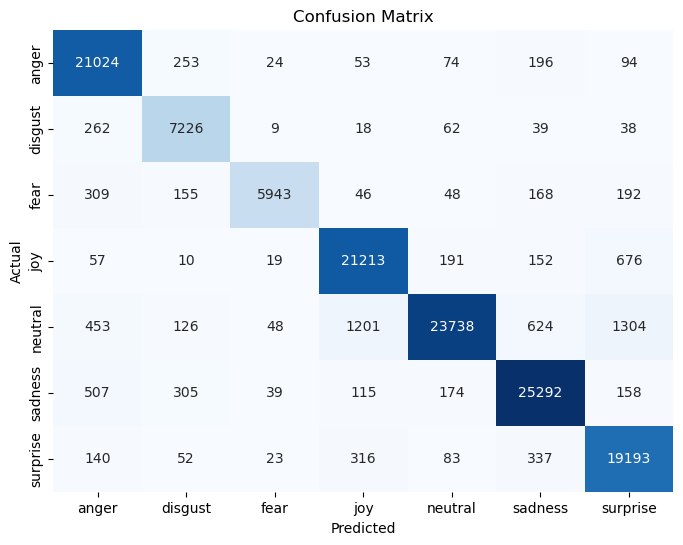

In [ ]:
import seaborn as sns

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['anger', 'disgust', 'fear','joy','neutral','sadness','surprise'],
            yticklabels=['anger', 'disgust', 'fear','joy','neutral','sadness','surprise'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.4/460.4 kB 15.8 MB/s eta 0:00:00


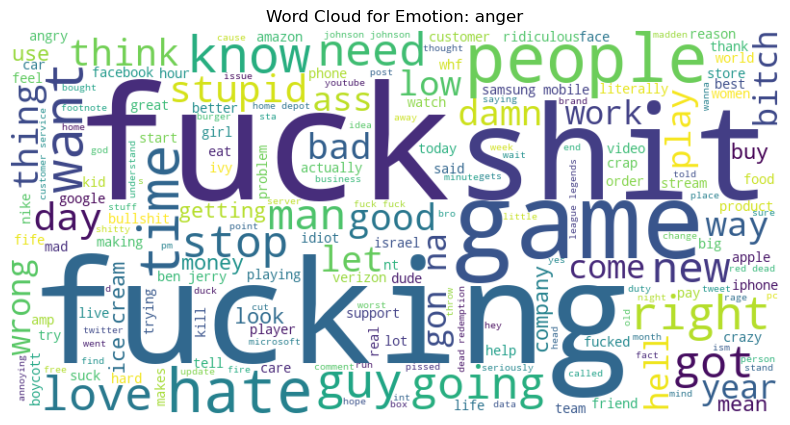

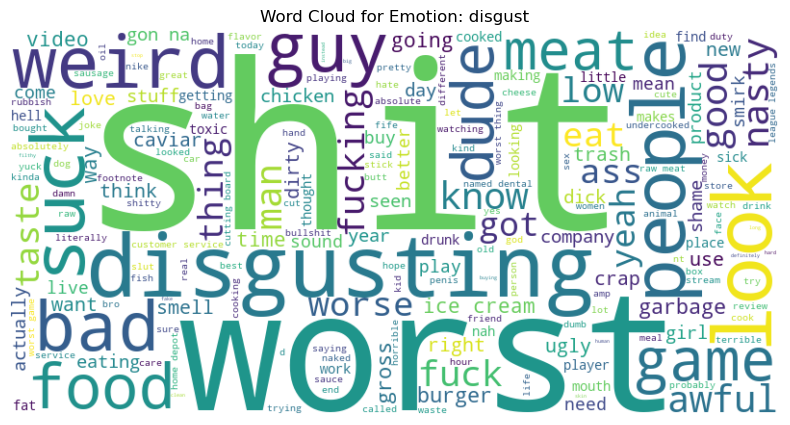

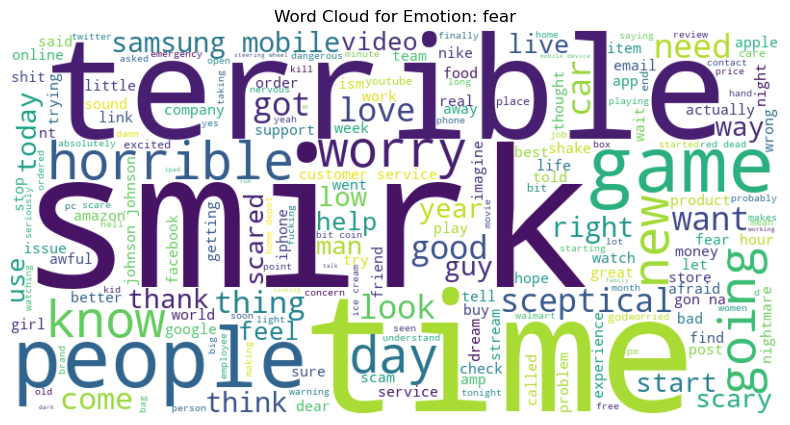

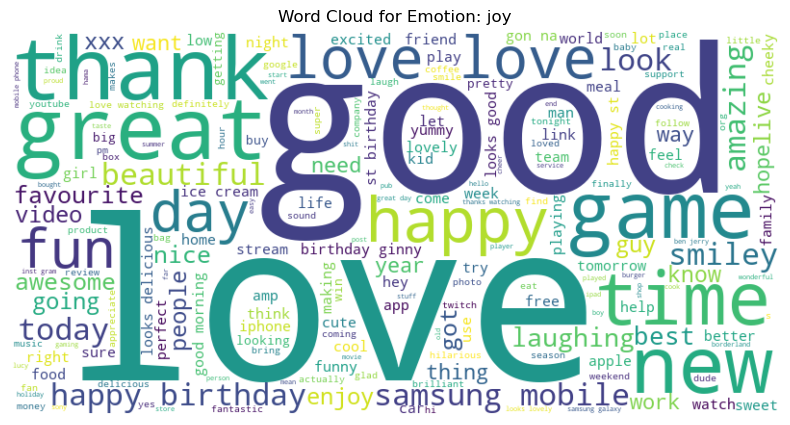

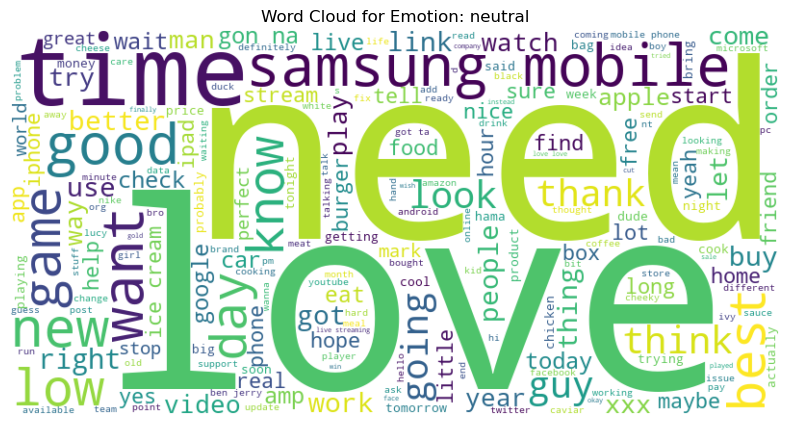

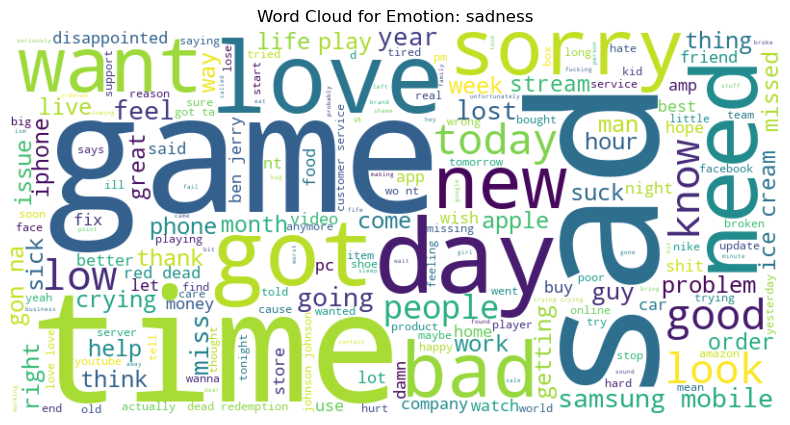

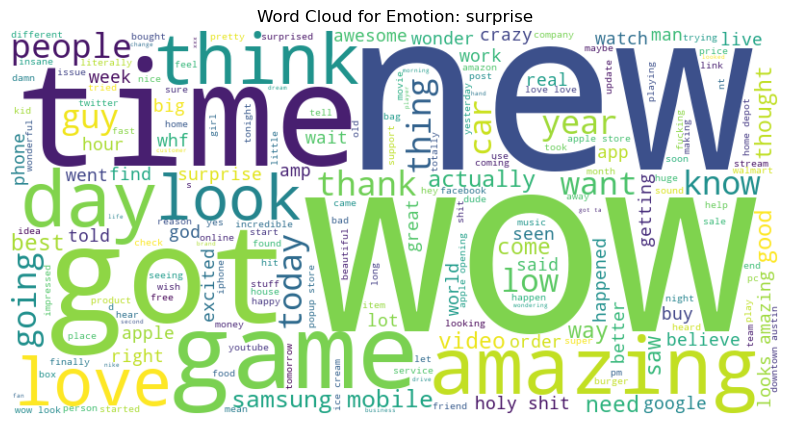

In [ ]:
from wordcloud import WordCloud

# Define a function to generate word clouds for a given emotion class
def generate_word_cloud(clean_txt_data, emotion_class):
    # Combine all clean_txt data for the specified emotion class
    clean_txt = ' '.join(balanced_df[balanced_df['label'] == emotion_class]['text'])

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(clean_txt)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Emotion: {emotion_class}')
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Call the function for each emotion class
emotion_classes = ['anger', 'disgust', 'fear','joy','neutral','sadness','surprise']

for emotion_class in emotion_classes:
    generate_word_cloud(balanced_df, emotion_class)
